# Autoencoder for the Kolmogorov Flow

In this session, you will need to use what you learned in the previous notebooks to develop a particular neural network called an autoencoder. The dataset comes from the simulation of the Kolmogorov flow:
\begin{equation}
    \nabla \cdot \mathbf{u} = 0
\end{equation}
\begin{equation}
    \frac{\partial \mathbf{u}}{\partial t} + \mathbf{u} \cdot \nabla  \mathbf{u} = -\nabla p + F + \frac{1}{Re} \nabla^2 \mathbf{u}
\end{equation}
where $F=(\sin(2\pi k y/L_y),0)$ where $L_x=L_y=2\pi$ and $k = 4$.

Different sets are provided at different Reynolds number (20, 30 and 40).

# Reynolds Number = 20

# 1. Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, UpSampling2D, concatenate, BatchNormalization, Conv2DTranspose
from sklearn.preprocessing import MinMaxScaler
import tensorflow_probability as tfp
from scipy.linalg import eigh
from numpy.linalg import eig


# 2. Read Dataset

In [2]:
#read dataset

hf = h5py.File('E:/Technische Universität Berlin/Master Luft- und Raumfahrttechnik/4. Semester/Machine Learning for Dynamical Systems/Project2/Project2/Data/ML_WORKSHOP_Kolmogorov_Re20_T1000_DT01.h5','r')

learnrate = 0.0001
Nx = 24 # Nx=24 for Re=20 or Re=30; Nx=48 for Re=40
Nu = 2
t = np.array(hf.get('t'))
u_all = np.zeros((Nx,Nx,len(t),Nu))
u_all[:,:,:,0] = np.array(hf.get('u_refined'))
#if Nu==2:
u_all[:,:,:,1] = np.array(hf.get('v_refined'))
u_all = np.transpose(u_all,[2,0,1,3])
#hf.close()
print(u_all.shape)

(1000, 24, 24, 2)


In [3]:
#choosing a test data set to assess the accuracy of our model
Ntrain = int(np.round(0.9*len(u_all)))
print(Ntrain)
u_all_train=u_all[:Ntrain,:,:,:]
print(u_all_train.shape)
u_all_test=u_all[Ntrain:,:,:,:]

900
(900, 24, 24, 2)


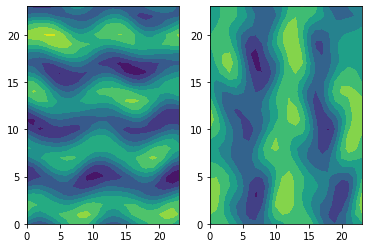

In [4]:
# visualization of the dataset
%matplotlib notebook
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(u_all[0,:,:,0])
#plt.colorbar(ax=ax)
ax2 = fig.add_subplot(122)
ax2.contourf(u_all[0,:,:,1])

# 3. Defining the Autoencoder

In [5]:
input_layer = tf.keras.Input(shape=(Nx, Nx, 2))

# Defining the encoder

x=tf.keras.layers.Conv2D(15,(3,3),activation='relu')(input_layer)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2D(10,(3,3),activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.BatchNormalization()(x)

encoded=tf.keras.layers.Conv2D(2,(3,3),activation='relu')(x)

# defining the decoder


x=tf.keras.layers.Conv2DTranspose(2,(3,3),activation='relu')(encoded)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.UpSampling2D((2,2))(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2DTranspose(10,(3,3),activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)
#x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.UpSampling2D((2,2))(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2DTranspose(15,(3,3),activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)

decoded=tf.keras.layers.Conv2DTranspose(2,(3,3),activation='linear')(x)



# defining the autoencoder

autoencoder=tf.keras.Model(input_layer,decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 24, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 22, 22, 15)        285       
                                                                 
 batch_normalization (BatchN  (None, 22, 22, 15)       60        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 22, 22, 15)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 15)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 15)       60    

# 4. Compiling the Model

In [6]:
# We use the adam optimizer for our first prediction

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learnrate),loss='mse')

# 5. Training the Model

In [7]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min', verbose=1,restore_best_weights=True )

hist = autoencoder.fit(u_all_train,u_all_train,batch_size=10,epochs=1000,validation_split=0.25, callbacks=[early_stop_callback])
loss_history = hist.history['loss']

Epoch 1/1000
68/68 [==============================] - 2s 8ms/step - loss: 1.4850 - val_loss: 0.0929
Epoch 2/1000
68/68 [==============================] - 0s 6ms/step - loss: 0.7293 - val_loss: 0.0946
Epoch 3/1000
68/68 [==============================] - 0s 6ms/step - loss: 0.4531 - val_loss: 0.0861
Epoch 4/1000
68/68 [==============================] - 0s 6ms/step - loss: 0.3160 - val_loss: 0.0818
Epoch 5/1000
68/68 [==============================] - 0s 6ms/step - loss: 0.2411 - val_loss: 0.0842
Epoch 6/1000
68/68 [==============================] - 0s 6ms/step - loss: 0.1964 - val_loss: 0.0882
Epoch 7/1000
68/68 [==============================] - 0s 6ms/step - loss: 0.1673 - val_loss: 0.0922
Epoch 8/1000
68/68 [==============================] - 0s 6ms/step - loss: 0.1479 - val_loss: 0.0934
Epoch 9/1000
68/68 [==============================] - 0s 6ms/step - loss: 0.1330 - val_loss: 0.0932
Epoch 10/1000
68/68 [==============================] - 0s 6ms/step - loss: 0.1220 - val_loss: 0.0917

# 6. Loss Evaluation

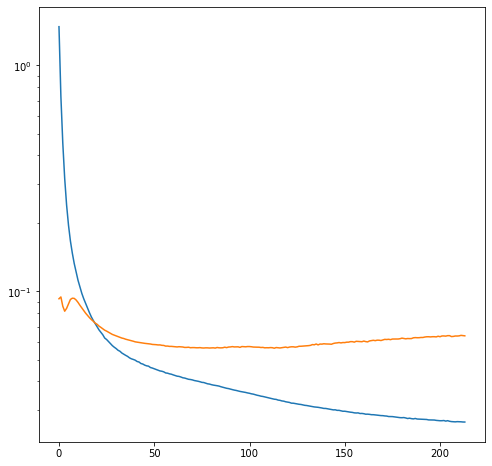

In [8]:
# we evaluate the loss for this model

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8,8))
plt.semilogy(loss, label= "training loss")
plt.semilogy(val_loss, label= "validation loss") 


# 7. Output Visualization

4/4 [==============================] - 0s 3ms/step


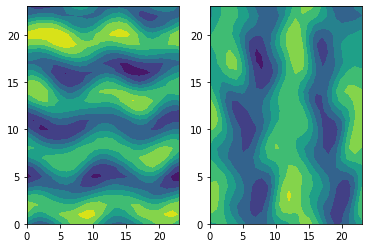

In [9]:
reconstructed_images=autoencoder.predict(u_all_test[:,:])
# visualization of the results
%matplotlib notebook
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(u_all_test[0,:,:,0])
#plt.colorbar(ax=ax)
ax2 = fig.add_subplot(122)
ax2.contourf(u_all_test[0,:,:,1])
plt.show()

# 8. Plotting the Mean Square Error

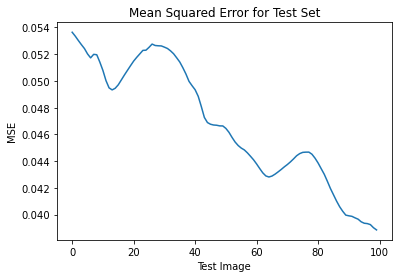

In [10]:
# Calculate the mean squared error between the original and reconstructed images for the test data
mse = np.mean(np.square(u_all_test - reconstructed_images), axis=(1, 2, 3))

# Plot the mean squared error for each test image
plt.plot(mse)
plt.title("Mean Squared Error for Test Set")
plt.xlabel("Test Image")
plt.ylabel("MSE")
plt.show()

# 9. Proper Orthogonal Decomposition

In [11]:
# Separate images for u and v components
u_all_u = u_all[:,:,:,0]

u_all_v = u_all[:,:,:,1]


# reshape into 2D
U = tf.reshape(u_all_u, [1000, 576])

V = tf.reshape(u_all_v, [1000,576])


# Transpose snapshot matrix
U_transpose = np.transpose(U)

V_transpose = np.transpose(V)


#Compute covariance matrix
C = np.matmul(U_transpose, U)*(1/999)

C2 = np.matmul(V_transpose, V)*(1/999)


In [12]:
# Solve eigenproblem
eigenvalues,eigenvectors=eig(C)

#plt.plot(eigenvalues)

eigenvalues_v,eigenvectors_v=eig(C2)


# Arrange eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

idx2 = eigenvalues_v.argsort()[::-1]   
eigenvalues_v = eigenvalues_v[idx2]
eigenvectors_v = eigenvectors_v[:,idx2]

In [13]:
eigenvectors_T = np.transpose(eigenvectors)
eigenvectors_T2 = np.transpose(eigenvectors_v)

#Compute A Matrix
A = np.matmul(U, eigenvectors)
print(A.shape)

#Number of modes
k=47


# Add k modes
first_col = A[:,0:k]
print(first_col.shape)

first_row = eigenvectors_T[0:k,:]
print(first_row.shape)

test=np.matmul(first_col,first_row)
print(test.shape)


A2 = np.matmul(V, eigenvectors_v)

first_col_v = A2[:,0:k]

first_row_v = eigenvectors_T2[0:k,:]

test2=np.matmul(first_col_v,first_row_v)



U_tilde = tf.reshape(test, [1000,24,24])

V_tilde = tf.reshape(test2, [1000,24,24])

(1000, 576)
(1000, 47)
(47, 576)
(1000, 576)


C:\Users\Diego Solis\anaconda3\lib\site-packages\numpy\ma\core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


Text(0.5, 1.0, 'Original Image')

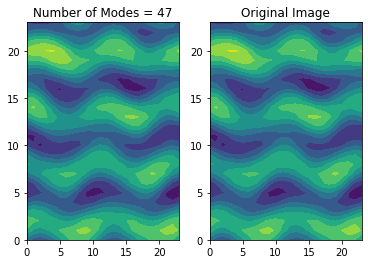

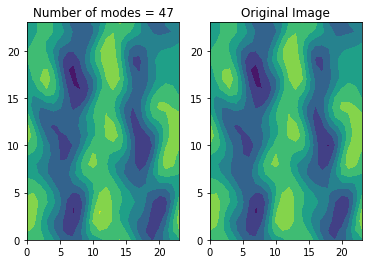

In [14]:
# visualization of the reconstructed and the original image
%matplotlib notebook
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(U_tilde[0,:,:])
plt.title("Number of Modes = 47")

ax2 = fig.add_subplot(122)
ax2.contourf(u_all[0,:,:,0])
plt.title("Original Image")






fig2 = plt.figure()
ax = fig2.add_subplot(121)
ax.contourf(V_tilde[0,:,:])

plt.title("Number of modes = 47")
ax2 = fig2.add_subplot(122)

ax2.contourf(u_all[0,:,:,1])
plt.title("Original Image")
#plt.colorbar(ax=ax)

C:\Users\Diego Solis\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Diego Solis\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


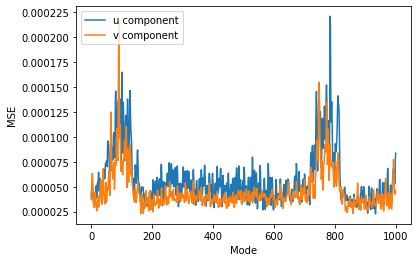

In [15]:
mse_POD_u = np.mean(np.square(u_all_u - U_tilde), axis=(1, 2))
mse_POD_v = np.mean(np.square(u_all_v - V_tilde), axis=(1, 2))
plt.plot( mse_POD_u, label="u component")
plt.plot( mse_POD_v, label = "v component")
plt.legend(loc='upper left')
plt.xlabel("Mode")
plt.ylabel("MSE")
plt.show()